In [17]:
from qiskit import *
%matplotlib inline
from qiskit.tools.visualization import plot_histogram

In [18]:
secretnumber = '0100'
n =  len(secretnumber)

In [19]:
circuit = QuantumCircuit(n+1, n+1)

circuit.h(range(n))
circuit.x(n)
circuit.h(n)
circuit.barrier()

for i,yesno in enumerate(reversed(secretnumber)):
    if (yesno == '1'):
        circuit.cx(i,n)

circuit.barrier()
circuit.h(range(n))
circuit.measure(range(n),range(n))

{'00100': 1}


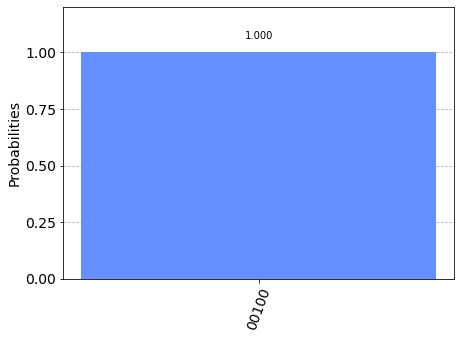

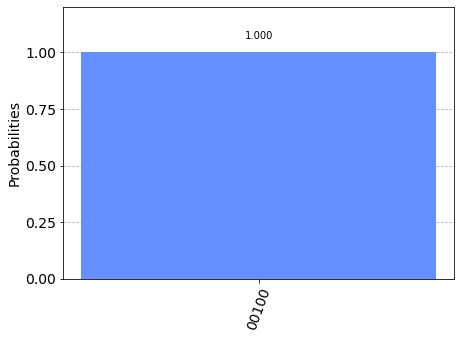

In [20]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend = simulator, shots = 1).result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

In [21]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_santiago')
job = execute(circuit, backend=qcomp)
from qiskit.tools.monitor import job_monitor
job_monitor(job)

ibmqfactory.load_account:WARNING:2021-07-18 22:21:04,970: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


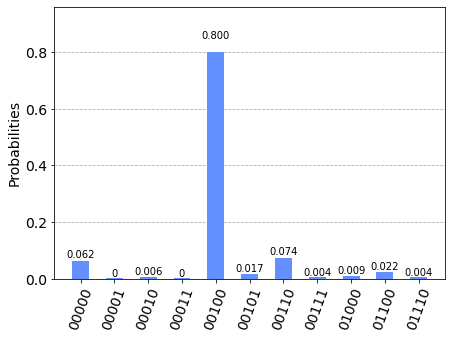

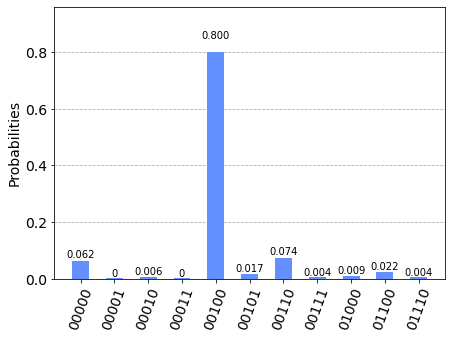

In [22]:
from qiskit.tools.visualization import plot_histogram
result = job.result()
plot_histogram(result.get_counts(circuit))

In [23]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qr = circuit.qregs[0], circlabel = 'measerrormitigationcal' )

cal_job = execute(cal_circuits,
    backend = qcomp,
    shots = 1024,
    optimization_level= 0
    )
print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()
print(len(cal_circuits))

60f45c29cef836b34ebbdbaf
Job Status: job has successfully run
32


In [24]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

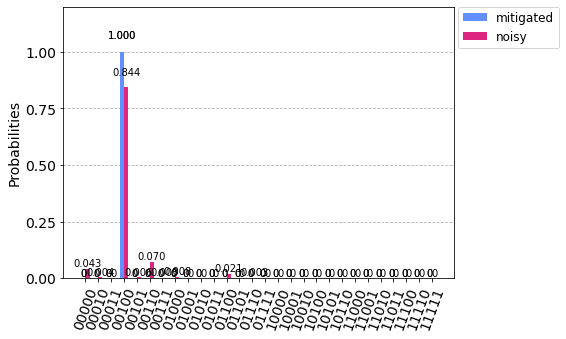

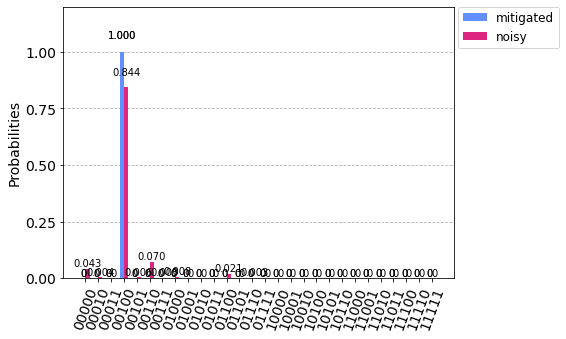

In [26]:
meas_filter = meas_fitter.filter
mitigated_result = meas_filter.apply(result)
device_counts = result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([counts, mitigated_counts], legend = ['mitigated', 'noisy'])